✅ All patches applied. SMOTE is ready to use.
✅ Data loaded. Shape: (151112, 26)

--- Split Status ---
Training Set: (120889, 25)
Test Set:     (30223, 25)
🔍 Diagnosing Missing Values in X_train...
lower_bound_ip_address    500
upper_bound_ip_address    500
dtype: int64

🛠️ Filling NaNs...
⚡ Applying SMOTE (Take 2)...

✅ SMOTE Successful!
--- Class Balance AFTER SMOTE ---
class
0    109568
1    109568
Name: count, dtype: int64

--- Class Balance AFTER SMOTE (Training Set) ---
class
0    109568
1    109568
Name: count, dtype: int64
Fraud Ratio: 0.5000


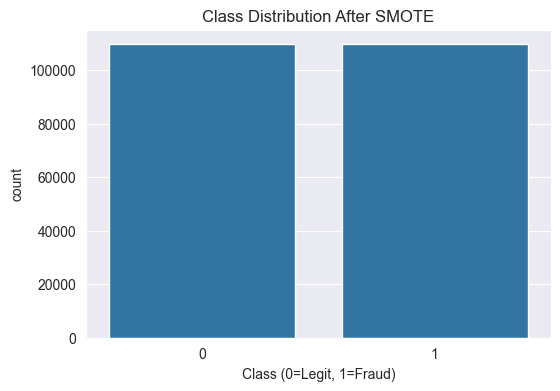

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import sklearn.utils.validation
import sklearn.ensemble

# --- PATCH 1: Fix '_is_pandas_df' (The error you solved before) ---
# imblearn looks for this function which sklearn removed. We add it back.
def _is_pandas_df(X):
    return isinstance(X, pd.DataFrame)

setattr(sklearn.utils.validation, '_is_pandas_df', _is_pandas_df)

# --- PATCH 2: Fix 'AdaBoostClassifier' (The new error) ---
# imblearn tries to initialize AdaBoost with algorithm="SAMME", but
# your modern sklearn removed the 'algorithm' parameter.
# We replace the class with a version that swallows that argument.

OriginalAdaBoost = sklearn.ensemble.AdaBoostClassifier

class PatchedAdaBoost(OriginalAdaBoost):
    def __init__(self, *args, **kwargs):
        # If 'algorithm' is passed, delete it so sklearn doesn't crash
        if 'algorithm' in kwargs:
            kwargs.pop('algorithm')
        super().__init__(*args, **kwargs)

# Inject our patched class into the library
sklearn.ensemble.AdaBoostClassifier = PatchedAdaBoost

# --- IMPORTS ---
# Now it is safe to import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

print("✅ All patches applied. SMOTE is ready to use.")
# 1. Load the Engineered Data
# We use the final version we just saved
df = pd.read_csv('../data/processed/fraud_data_feature_engineered.csv')
print(f"✅ Data loaded. Shape: {df.shape}")

# 2. Separate Features (X) and Target (y)
# 'class' is our target variable
X = df.drop(columns=['class'])
y = df['class']

# 3. Stratified Train-Test Split [cite: 1174]
# We MUST do this before SMOTE to prevent data leakage.
# Stratify=y ensures the % of fraud is the same in both sets initially.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Split Status ---")
print(f"Training Set: {X_train.shape}")
print(f"Test Set:     {X_test.shape}")

# 4. Handle Class Imbalance (SMOTE) [cite: 1166-1169]
# We apply this ONLY to X_train, y_train.
#
# print("\n--- Class Balance BEFORE SMOTE (Training Set) ---")
# print(y_train.value_counts())
# print(f"Fraud Ratio: {y_train.value_counts(normalize=True)[1]:.4f}")
#
# print("\n⚡ Applying SMOTE... (This may take a moment)")
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE # Ensure SMOTE is imported if not already

# --- REPLACEMENT FOR STEP 4 ---

# 1. Diagnose: Check which columns have hidden NaNs
print("🔍 Diagnosing Missing Values in X_train...")
missing_cols = X_train.isnull().sum()
print(missing_cols[missing_cols > 0])

# 2. Impute: Fill NaNs with the mean
# We fit the imputer ONLY on X_train to avoid data leakage
imputer = SimpleImputer(strategy='mean')

print("\n🛠️ Filling NaNs...")
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Note: We don't strictly need to transform X_test yet, but we will need the imputer later.

# 3. Apply SMOTE (Now on the clean data)
print("⚡ Applying SMOTE (Take 2)...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train)

# 4. Success Check
print("\n✅ SMOTE Successful!")
print("--- Class Balance AFTER SMOTE ---")
print(y_train_resampled.value_counts())
# 5. Document the Result [cite: 1169]
print("\n--- Class Balance AFTER SMOTE (Training Set) ---")
print(y_train_resampled.value_counts())
print(f"Fraud Ratio: {y_train_resampled.value_counts(normalize=True)[1]:.4f}")

# 6. Justification Visualization (Optional but great for report)
# Show that the classes are now 50/50
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class (0=Legit, 1=Fraud)')
plt.show()

# 7. Save the Split Data (Optional)
# Often we just keep variables in memory, but saving ensures reproducibility.
X_train_resampled.to_csv('../data/processed/X_train_smote.csv', index=False)
y_train_resampled.to_csv('../data/processed/y_train_smote.csv', index=False)
